In [176]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from cytoolz import *
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [72]:
with open('weekly-closings-of-the-dowjones-.csv') as f:
    r = csv.reader(f)
    raw_data = list(r)[1:-3]

dataframe = pd.read_csv('weekly-closings-of-the-dowjones-.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [60]:
def discretize_labels(data):
    result = []
    for i in range(len(data)):
        result.append([i, float(data[i][1])])
    return result

#labeled = np.array(discretize_labels(raw_data))
values = np.array([float(v[1]) for v in raw_data])

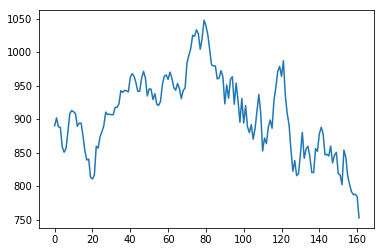

In [73]:
plt.plot(dataset)
plt.show()

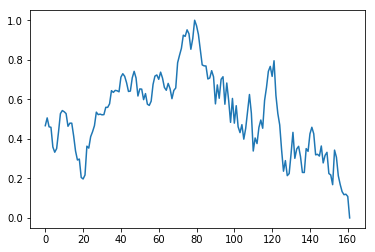

In [98]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.plot(dataset)
plt.show()

In [111]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

129 33


In [117]:
def create_dataset(dataset, look_back=4):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [197]:
look_back = 4
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [198]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='logcosh', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0361
Epoch 2/100
 - 0s - loss: 0.0115
Epoch 3/100
 - 0s - loss: 0.0112
Epoch 4/100
 - 0s - loss: 0.0089
Epoch 5/100
 - 0s - loss: 0.0088
Epoch 6/100
 - 0s - loss: 0.0075
Epoch 7/100
 - 0s - loss: 0.0080
Epoch 8/100
 - 0s - loss: 0.0070
Epoch 9/100
 - 0s - loss: 0.0074
Epoch 10/100
 - 0s - loss: 0.0059
Epoch 11/100
 - 0s - loss: 0.0068
Epoch 12/100
 - 0s - loss: 0.0062
Epoch 13/100
 - 0s - loss: 0.0041
Epoch 14/100
 - 0s - loss: 0.0057
Epoch 15/100
 - 0s - loss: 0.0054
Epoch 16/100
 - 0s - loss: 0.0044
Epoch 17/100
 - 0s - loss: 0.0047
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0050
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0042
Epoch 22/100
 - 0s - loss: 0.0046
Epoch 23/100
 - 0s - loss: 0.0038
Epoch 24/100
 - 0s - loss: 0.0043
Epoch 25/100
 - 0s - loss: 0.0032
Epoch 26/100
 - 0s - loss: 0.0044
Epoch 27/100
 - 0s - loss: 0.0033
Epoch 28/100
 - 0s - loss: 0.0037
Epoch 29/100
 - 0s - loss: 0.0037
Epoch 30/100
 - 0s - lo

In [199]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.08 RMSE


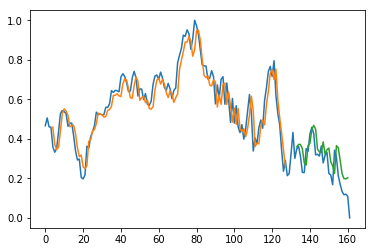

In [200]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()